# GoogleNET Implementation

### Importing Libraries

In [33]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Grayscale
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchsummary
from tqdm import tqdm

### Data Augmentation

Defineing two image preprocessing pipelines using PyTorch’s transforms. Compose—one for training and one for validation/testing. The train_transforms pipeline includes resizing to 224×224 pixels, followed by data augmentation techniques like random horizontal and vertical flips, random rotation, and brightness/contrast jittering to improve model robustness and prevent overfitting. It then converts images to tensors and normalizes them using ImageNet’s mean and standard deviation values. The val_test_transforms pipeline is simpler, applying only resizing, tensor conversion, and normalization to ensure consistent input formatting without altering image content during evaluation.

In [2]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize to model input size
    transforms.RandomHorizontalFlip(),    # Random horizontal flipping
    transforms.RandomRotation(20),        # Random rotation
    transforms.RandomVerticalFlip(),      # Random vertical flipping
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2),  # Color jittering
    transforms.ToTensor(),                # Convert to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Loading Dataset

Loading an image dataset from the "AlzheimerDataset" directory using PyTorch’s ImageFolder, which expects images to be organized in subdirectories named after their class labels. It applies different transformation pipelines to the training, validation, and test sets. Data augmentation for training and only resizing and normalization for validation and testing. The last two lines print out the list of class names detected in the dataset and the corresponding mapping of each class to a numeric index.

In [3]:
dataset_path = '/Users/sravan/Downloads/DL/DL Project/archive/AlzheimerDataset'
batch_size = 32
train_data = ImageFolder(root = dataset_path, transform = train_transforms)
val_data = ImageFolder(root = dataset_path, transform = val_test_transforms)
test_data = ImageFolder(root = dataset_path, transform = val_test_transforms)
print(f'Classes: {train_data.classes}')
print(f'Class-to-Index Mapping: {train_data.class_to_idx}')

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False, num_workers = 2)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = 2)

Classes: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
Class-to-Index Mapping: {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


In [4]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

### Number of images per class

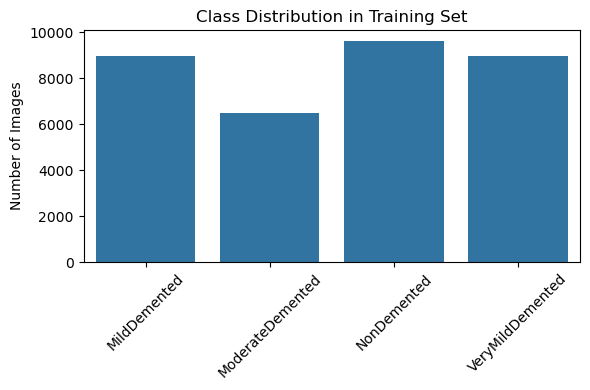

In [5]:
class_counts = Counter([label for _, label in train_data.imgs])
labels = [train_data.classes[i] for i in class_counts.keys()]
counts = list(class_counts.values())

plt.figure(figsize = (6, 4))
sns.barplot(x = labels, y = counts)
plt.title('Class Distribution in Training Set')
plt.ylabel('Number of Images')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### Training data summary

Statistics

In [6]:
image_shapes = []
for path, _ in train_data.imgs:
    with Image.open(path) as img:
        image_shapes.append(img.size)

shape_df = pd.DataFrame(image_shapes, columns=['Width', 'Height'])
print(shape_df.describe())

              Width        Height
count  33984.000000  33984.000000
mean     196.233522    188.116761
std        7.819527      3.909764
min      180.000000    180.000000
25%      200.000000    190.000000
50%      200.000000    190.000000
75%      200.000000    190.000000
max      200.000000    190.000000


In [7]:
def compute_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images = 0

    for images, _ in tqdm(loader):
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

eda_loader = DataLoader(train_data, batch_size = 32, shuffle = False, num_workers = 2)
mean, std = compute_mean_std(eda_loader)
print('Computed Mean:', mean)
print('Computed Std:', std)

100%|███████████████████████████████████████| 1062/1062 [00:38<00:00, 27.63it/s]

Computed Mean: tensor([-0.8379, -0.7273, -0.5014])
Computed Std: tensor([1.3083, 1.3374, 1.3315])


### Random images from the dataset with class names

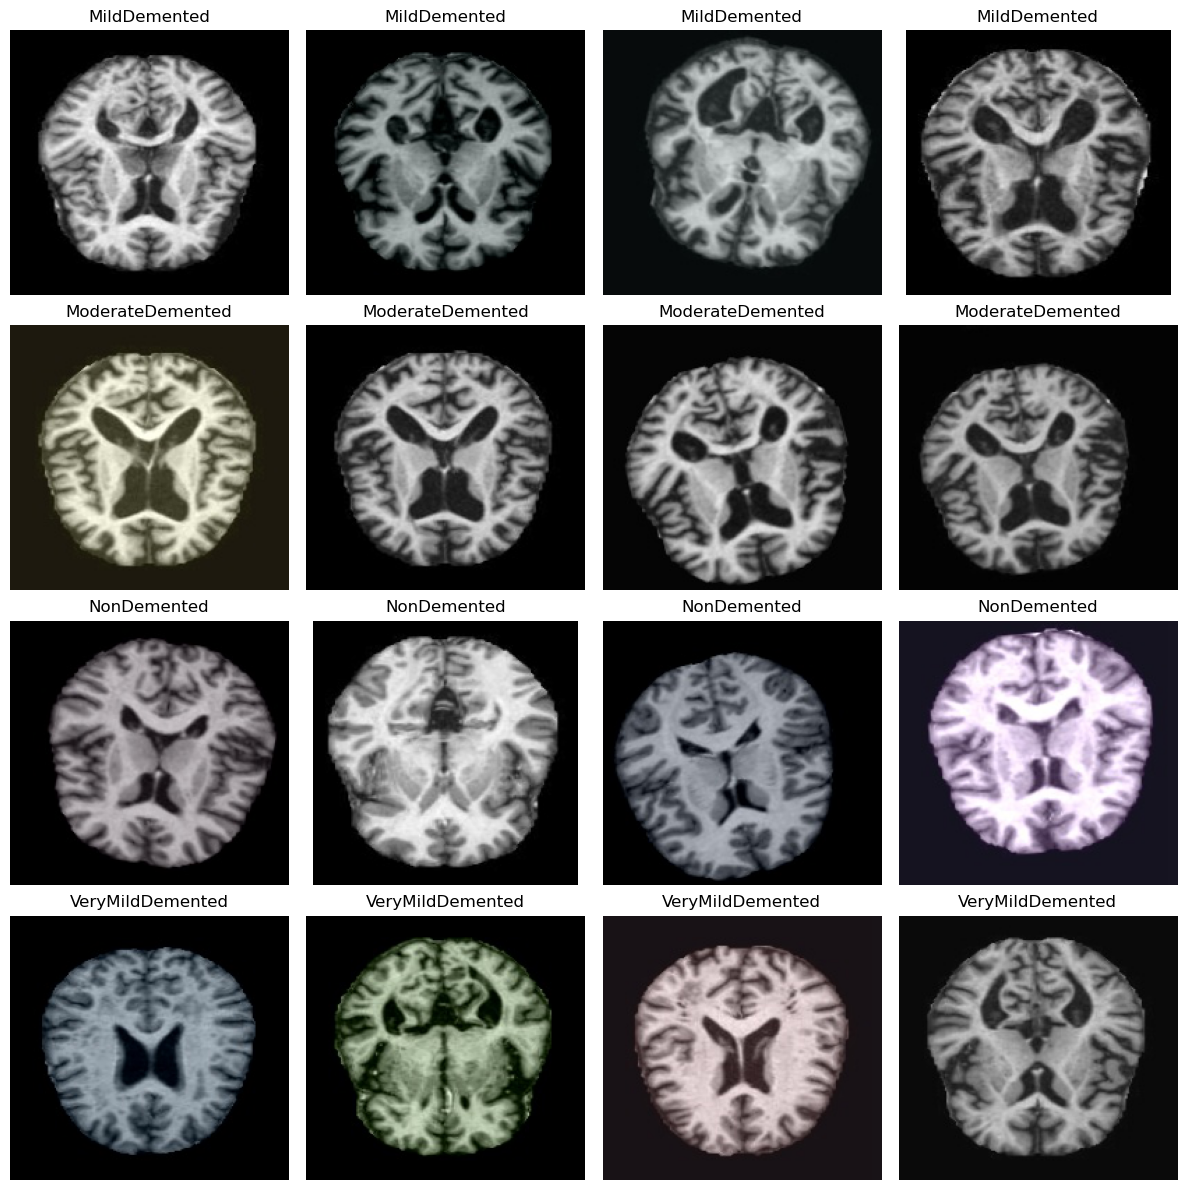

In [8]:
def show_images_by_class(dataset, class_names, samples_per_class = 4):
    fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(samples_per_class * 3, len(class_names) * 3))
    for i, class_name in enumerate(class_names):
        class_idx = dataset.class_to_idx[class_name]
        indices = [j for j, (_, label) in enumerate(dataset.imgs) if label == class_idx]
        sampled_indices = random.sample(indices, samples_per_class)
        for k, idx in enumerate(sampled_indices):
            img_path, _ = dataset.imgs[idx]
            image = Image.open(img_path)
            axes[i, k].imshow(image)
            axes[i, k].set_title(class_name)
            axes[i, k].axis('off')
    plt.tight_layout()
    plt.show()

show_images_by_class(train_data, train_data.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0775862].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.027450979..1.0296907].


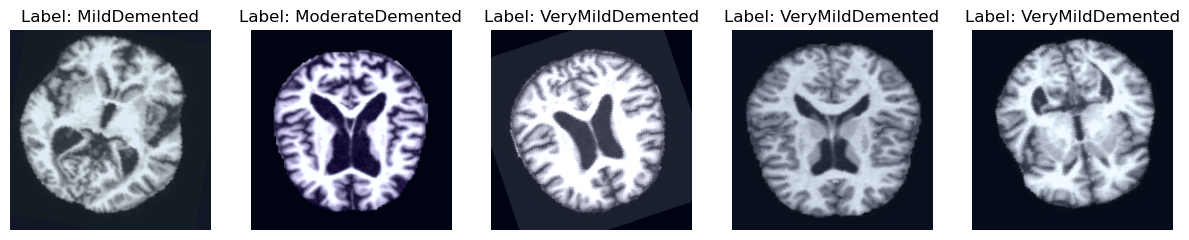

In [9]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].numpy().transpose((1, 2, 0))
    image = image * 0.229 + 0.485
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {train_data.classes[labels[i]]}')
    axes[i].axis('off')

plt.show()

### Balancing classes using weighted sampling

Handling class imbalance in the training dataset by applying weighted random sampling. It first counts the number of samples in each class using Counter, then computes class weights inversely proportional to their frequencies—giving higher weights to underrepresented classes. Each training sample is then assigned a corresponding weight. A WeightedRandomSampler is used to sample data such that all classes are represented more evenly during training. This sampler is passed to a DataLoader to ensure balanced batches. Finally, a message confirms that class balancing has been successfully applied.

In [10]:
class_counts = Counter(train_data.targets)
total_count = sum(class_counts.values())
class_weights = {cls: total_count / count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in train_data.targets]

sampler = WeightedRandomSampler(weights, num_samples = len(weights), replacement = True)

train_loader = DataLoader(train_data, batch_size = batch_size, sampler = sampler, num_workers = 2)

print('Class balancing using weighted sampling is applied!')

Class balancing using weighted sampling is applied!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.054901958..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.015686303..1.0616211].


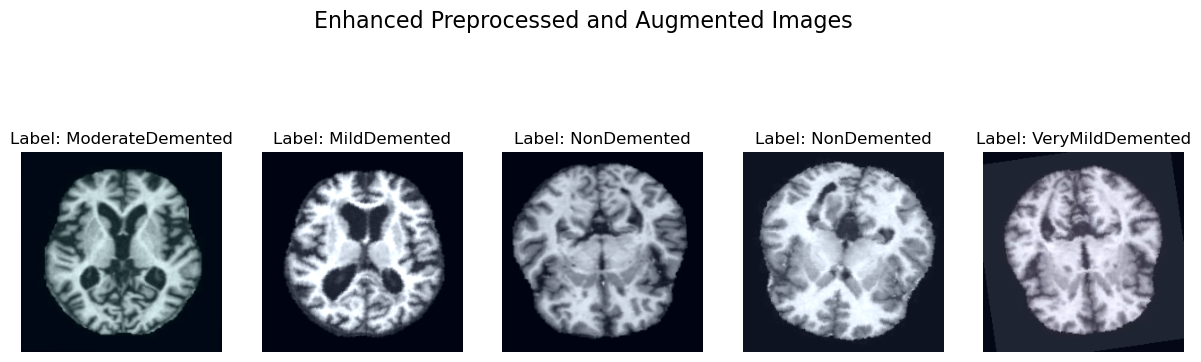

In [11]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].numpy().transpose((1, 2, 0))
    image = image * 0.229 + 0.485
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {train_data.classes[labels[i]]}')
    axes[i].axis('off')

plt.suptitle('Enhanced Preprocessed and Augmented Images', fontsize = 16)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.019607842..1.0256994].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.08956].


Batch Size: 32
Image Shape: torch.Size([32, 3, 224, 224])
Image Mean: -0.7628, Image Std: 1.3447


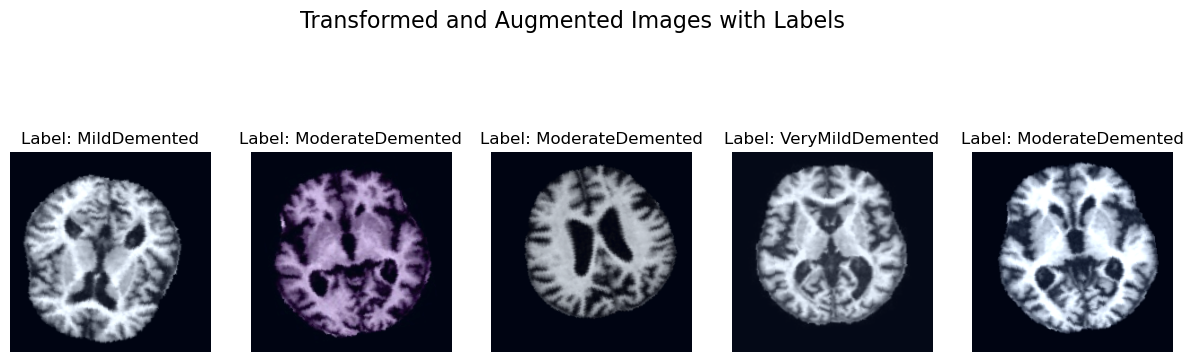

In [12]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f'Batch Size: {images.size(0)}')
print(f'Image Shape: {images.shape}')
print(f'Image Mean: {images.mean().item():.4f}, Image Std: {images.std().item():.4f}')

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    image = images[i].numpy().transpose((1, 2, 0))  # Convert from tensor to image
    image = image * 0.229 + 0.485
    axes[i].imshow(image.squeeze(), cmap='gray')
    label_index = labels[i].item()
    axes[i].set_title(f'Label: {train_data.classes[label_index]}')
    axes[i].axis('off')

plt.suptitle('Transformed and Augmented Images with Labels', fontsize = 16)
plt.show()

### Defining GoogleNET model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import time
import copy
import numpy as np
from tqdm import tqdm

class InceptionBlock(nn.Module):
    def __init__(self, in_channels, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_proj):
        super(InceptionBlock, self).__init__()
        
        # 1x1 convolution branch
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, n1x1, kernel_size = 1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(inplace = True)
        )
        
        # 1x1 -> 3x3 convolution branch
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, n3x3red, kernel_size = 1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(inplace = True),
            nn.Conv2d(n3x3red, n3x3, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(inplace = True)
        )
        
        # 1x1 -> 5x5 convolution branch
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, n5x5red, kernel_size = 1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(inplace = True),
            nn.Conv2d(n5x5red, n5x5, kernel_size = 5, padding = 2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(inplace = True)
        )
        
        # 3x3 pool -> 1x1 convolution branch
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(in_channels, pool_proj, kernel_size = 1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(inplace = True)
        )
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], 1)

class GoogleNet(nn.Module):
    def __init__(self, num_classes = 4):
        super(GoogleNet, self).__init__()
        
        # Initial layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.Conv2d(64, 192, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )
        
        # Inception blocks
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.dropout = nn.Dropout(0.4)
        
        self.fc = nn.Linear(1024, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Inception blocks
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        
        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

In [14]:
model = GoogleNet(num_classes = 4)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

5992212
GoogleNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (inception3a): InceptionBlock(
    (branch1): Sequential(
      (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

### Training the model

In [26]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    
    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        model.train()
        epoch_train_loss = 0.0
        epoch_train_corrects = 0
        
        for inputs, labels in tqdm(train_loader, desc = f'Training epoch {epoch+1}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
            epoch_train_corrects += torch.sum(preds == labels.data)
        
        if scheduler is not None:
            scheduler.step()
        
        epoch_train_loss = epoch_train_loss / len(train_loader.dataset)
        epoch_train_acc = epoch_train_corrects.float() / len(train_loader.dataset)
        
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc.cpu().numpy())
        
        print(f'Train Loss: {epoch_train_loss:.4f} Train Accuracy: {epoch_train_acc:.4f}')
        

        model.eval()
        epoch_val_loss = 0.0
        epoch_val_corrects = 0
        
        for inputs, labels in tqdm(val_loader, desc = f'Validation epoch {epoch+1}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
            
            epoch_val_loss += loss.item() * inputs.size(0)
            epoch_val_corrects += torch.sum(preds == labels.data)
        
        epoch_val_loss = epoch_val_loss / len(val_loader.dataset)
        epoch_val_acc = epoch_val_corrects.float() / len(val_loader.dataset)
        
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc.cpu().numpy())
        
        print(f'Validation Loss: {epoch_val_loss:.4f} Validation Accuracy: {epoch_val_acc:.4f}\n')
        
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            torch.save(model.state_dict(), "best_model.pt")
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best Val Acc: {best_acc:.4f}')
    
    return model, metrics, train_loss, train_acc, val_loss, val_acc

device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)

model, metrics, train_loss, train_acc, val_loss, val_acc = train_model(model, criterion, optimizer, scheduler, num_epochs = 10)

mps
Epoch 1/10


Training epoch 1: 100%|█████████████████████| 1062/1062 [05:30<00:00,  3.22it/s]


Train Loss: 0.2942 Train Accuracy: 0.8781


Validation epoch 1: 100%|███████████████████| 1062/1062 [02:18<00:00,  7.66it/s]


Validation Loss: 0.2509 Validation Accuracy: 0.8943

Epoch 2/10


Training epoch 2: 100%|█████████████████████| 1062/1062 [05:27<00:00,  3.24it/s]


Train Loss: 0.2657 Train Accuracy: 0.8916


Validation epoch 2: 100%|███████████████████| 1062/1062 [02:17<00:00,  7.74it/s]


Validation Loss: 0.5186 Validation Accuracy: 0.8004

Epoch 3/10


Training epoch 3: 100%|█████████████████████| 1062/1062 [05:27<00:00,  3.24it/s]


Train Loss: 0.2373 Train Accuracy: 0.9039


Validation epoch 3: 100%|███████████████████| 1062/1062 [02:19<00:00,  7.62it/s]


Validation Loss: 0.6489 Validation Accuracy: 0.7783

Epoch 4/10


Training epoch 4: 100%|█████████████████████| 1062/1062 [05:28<00:00,  3.23it/s]


Train Loss: 0.2214 Train Accuracy: 0.9114


Validation epoch 4: 100%|███████████████████| 1062/1062 [02:16<00:00,  7.76it/s]


Validation Loss: 0.8227 Validation Accuracy: 0.7298

Epoch 5/10


Training epoch 5: 100%|█████████████████████| 1062/1062 [05:35<00:00,  3.16it/s]


Train Loss: 0.1825 Train Accuracy: 0.9276


Validation epoch 5: 100%|███████████████████| 1062/1062 [02:22<00:00,  7.46it/s]


Validation Loss: 0.2158 Validation Accuracy: 0.9177

Epoch 6/10


Training epoch 6: 100%|█████████████████████| 1062/1062 [05:35<00:00,  3.17it/s]


Train Loss: 0.1776 Train Accuracy: 0.9316


Validation epoch 6: 100%|███████████████████| 1062/1062 [02:21<00:00,  7.50it/s]


Validation Loss: 0.1588 Validation Accuracy: 0.9368

Epoch 7/10


Training epoch 7: 100%|█████████████████████| 1062/1062 [05:22<00:00,  3.29it/s]


Train Loss: 0.1578 Train Accuracy: 0.9402


Validation epoch 7: 100%|███████████████████| 1062/1062 [02:27<00:00,  7.21it/s]


Validation Loss: 0.1375 Validation Accuracy: 0.9436

Epoch 8/10


Training epoch 8: 100%|█████████████████████| 1062/1062 [05:30<00:00,  3.21it/s]


Train Loss: 0.0843 Train Accuracy: 0.9687


Validation epoch 8: 100%|███████████████████| 1062/1062 [02:22<00:00,  7.46it/s]


Validation Loss: 0.0289 Validation Accuracy: 0.9906

Epoch 9/10


Training epoch 9: 100%|█████████████████████| 1062/1062 [05:20<00:00,  3.32it/s]


Train Loss: 0.0673 Train Accuracy: 0.9760


Validation epoch 9: 100%|███████████████████| 1062/1062 [02:27<00:00,  7.22it/s]


Validation Loss: 0.0225 Validation Accuracy: 0.9923

Epoch 10/10


Training epoch 10: 100%|████████████████████| 1062/1062 [05:30<00:00,  3.21it/s]


Train Loss: 0.0579 Train Accuracy: 0.9781


Validation epoch 10: 100%|██████████████████| 1062/1062 [02:21<00:00,  7.49it/s]

Validation Loss: 0.0234 Validation Accuracy: 0.9921

Training complete in 78m 25s
Best Val Acc: 0.9923


### Training and Validation loss curves

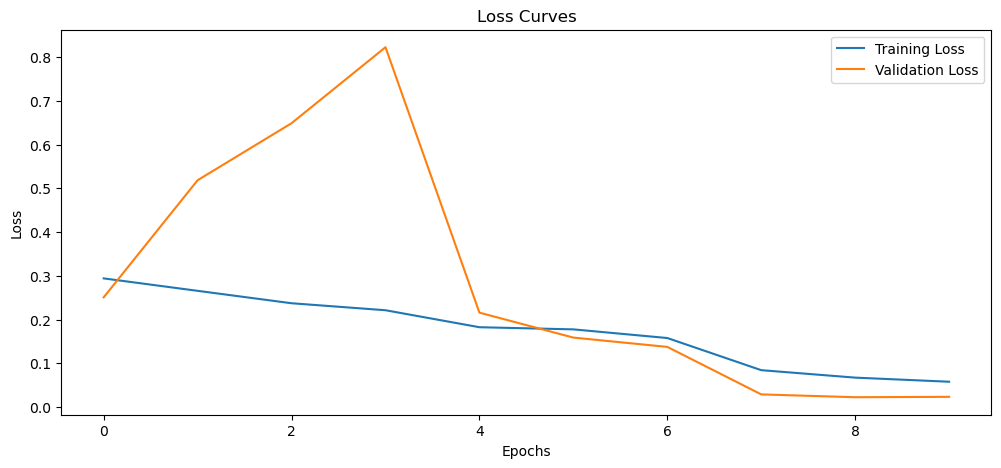

In [29]:
plt.figure(figsize=(12, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Training and Validation Accuracy curves

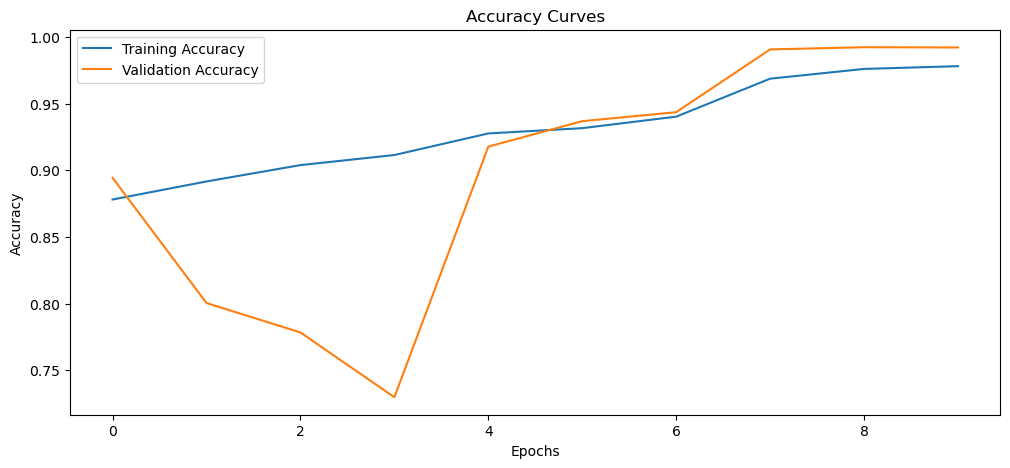

In [30]:
plt.figure(figsize=(12, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

### Testing the model

Testing: 100%|██████████████████████████████| 1062/1062 [02:14<00:00,  7.88it/s]


Test Accuracy: 0.9921

Classification Report:
                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00      8960
ModerateDemented       1.00      1.00      1.00      6464
     NonDemented       0.98      0.99      0.99      9600
VeryMildDemented       0.99      0.98      0.99      8960

        accuracy                           0.99     33984
       macro avg       0.99      0.99      0.99     33984
    weighted avg       0.99      0.99      0.99     33984



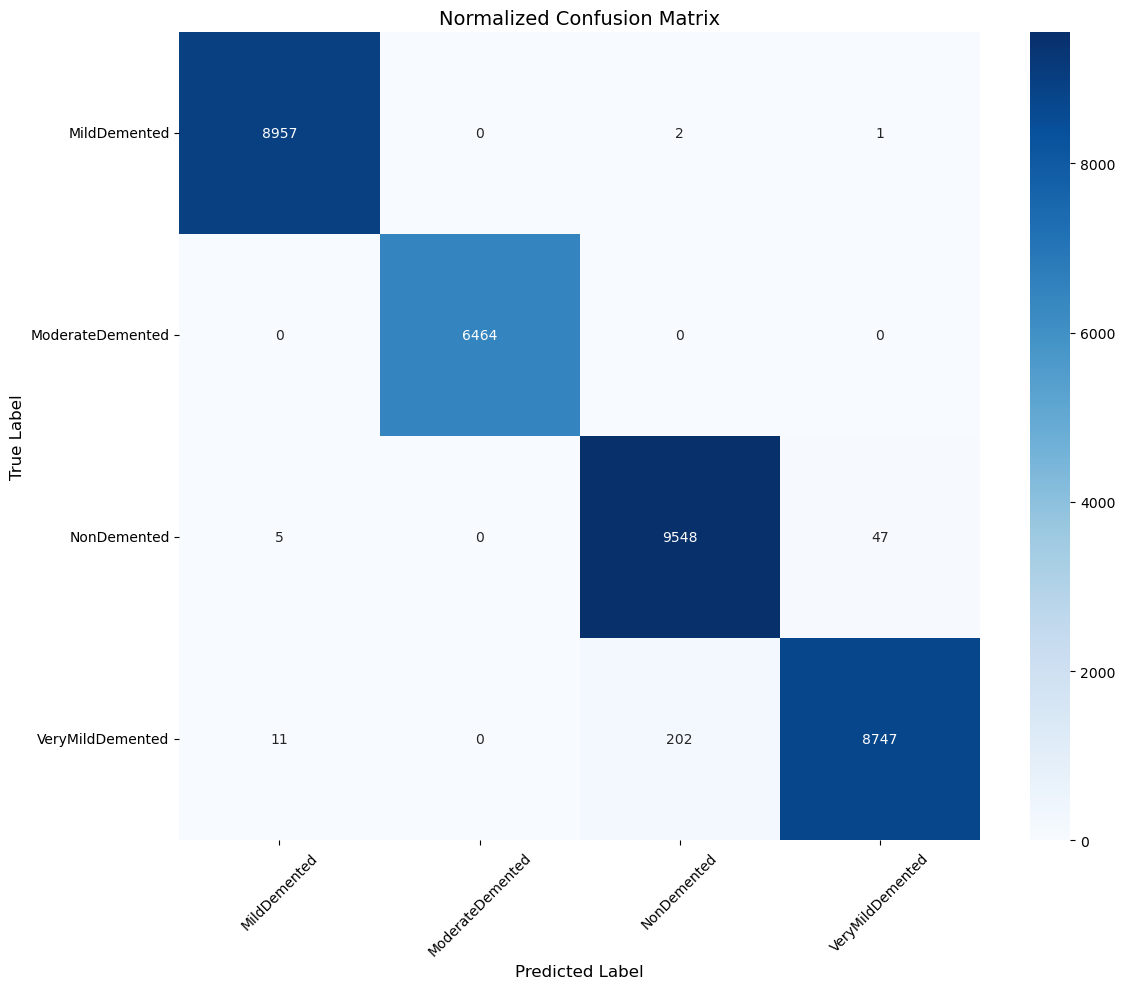

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def test_model(model, test_loader, device, class_names):
    model.eval()
    y_true = []
    y_pred = []
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    clf_report = classification_report(y_true, y_pred, target_names=class_names)
    cm = confusion_matrix(y_true, y_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:\n{clf_report}")
    
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues', xticklabels=class_names,  yticklabels=class_names)
    plt.title('Normalized Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return accuracy

test_accuracy = test_model(model = model, test_loader = test_loader, device = device, class_names = test_data.classes)

### Random predictions made by the model

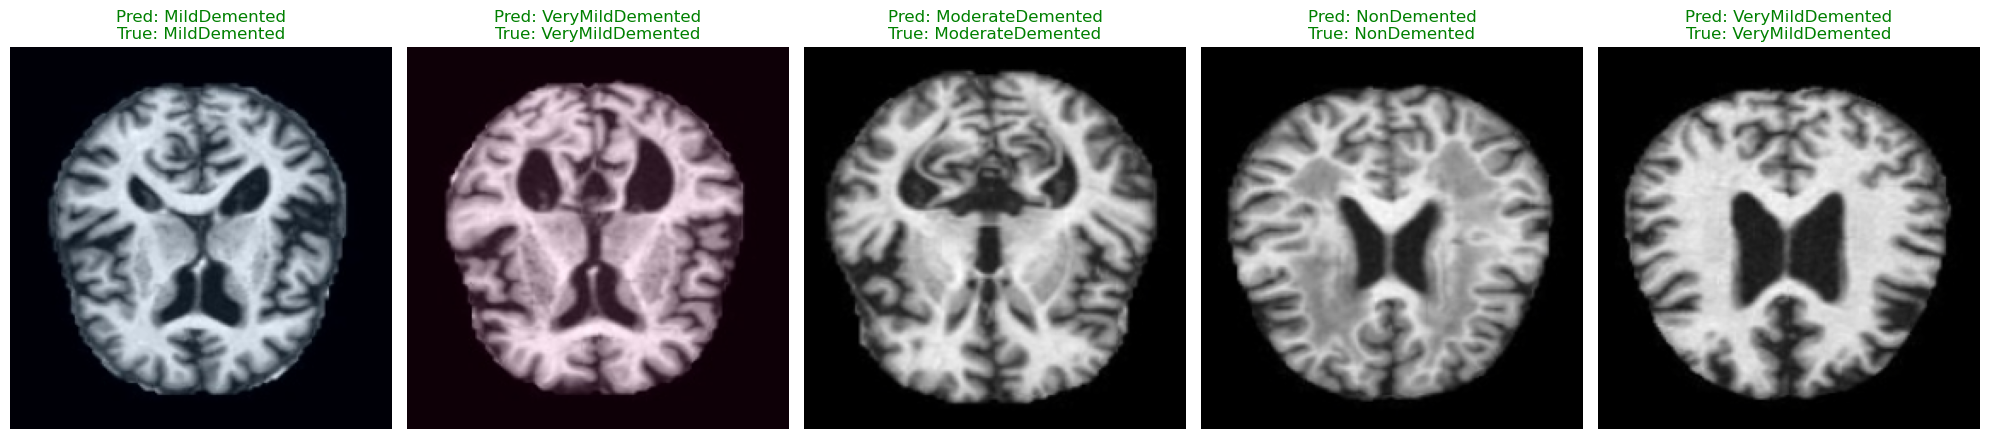

In [37]:
def visualize_random_predictions(model, data_loader, class_names, num_images=5):
    model.eval()
    class_samples = {class_idx: [] for class_idx in range(len(class_names))}
    for images, labels in data_loader:
        for img, label in zip(images, labels):
            if len(class_samples[label.item()]) < num_images:
                class_samples[label.item()].append((img, label))
        if all(len(v) >= num_images for v in class_samples.values()):
            break
    selected_samples = []
    for class_idx in class_samples:
        selected_samples.extend(random.sample(class_samples[class_idx], min(num_images, len(class_samples[class_idx]))))
    random.shuffle(selected_samples)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 8))
    if num_images == 1:
        axes = [axes]
    
    for (img, true_label), ax in zip(selected_samples[:num_images], axes):
        img = img.to(device)
        img_np = img.cpu().numpy().transpose((1, 2, 0))
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        
        with torch.no_grad():
            output = model(img.unsqueeze(0))
            _, pred = torch.max(output, 1)
        
        ax.imshow(img_np)
        ax.set_title(f"Pred: {class_names[pred.item()]}\nTrue: {class_names[true_label.item()]}", 
                    fontsize=12, color='green' if pred == true_label else 'red')
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
visualize_random_predictions(model, val_loader, class_names, num_images=5)